In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


/Users/george/Documents/bot2/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [46]:
# Load the CSV file
data = pd.read_csv('../data/year_delta.csv')

# Change all empty of inf values to 0.0
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0.0)

 # Filter by symbol, get only AAPL data
data = data[data['act_symbol'] == 'NVDA']

# Separate features (X) and target (y)
features = data.drop(columns=['adjusted_price', 'date', 'act_symbol'])
target = data['adjusted_price']

# Do not include the last most row
features = features[:-1]

# drop problematic columns entirely
features = features.dropna(axis=1)

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_features = scaler_X.fit_transform(features)
scaled_target = scaler_y.fit_transform(target.values.reshape(-1, 1))


In [47]:
def create_sequences(features, target, time_steps):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i+time_steps])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 4
X, y = create_sequences(scaled_features, scaled_target, time_steps)

# Split into train and test sets
split_idx = int(len(X) * .8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [48]:
model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)  # Predict the next quarter's adjusted_price
])

model.compile(optimizer='adam', loss='mean_squared_error')


/Users/george/Documents/bot2/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step - loss: 0.4169 - val_loss: 0.2455
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0565 - val_loss: 0.1150
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0568 - val_loss: 0.2479
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1537 - val_loss: 0.2666
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1433 - val_loss: 0.1942
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0756 - val_loss: 0.1274
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0208 - val_loss: 0.1084
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0056 - val_loss: 0.1284
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0215 - val_loss: 0.1572
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0449 - val_loss: 0.1708
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0568 - val_loss: 0.1636
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0520 - val_loss: 0.1438


In [50]:
# Predict the next quarter
latest_sequence = scaled_features[-time_steps:].reshape(1, time_steps, scaled_features.shape[1])
predicted_scaled_price = model.predict(latest_sequence)

# Inverse transform to get the actual price
predicted_price = scaler_y.inverse_transform(predicted_scaled_price)

print(f"Predicted Adjusted Price for the Next Quarter: {predicted_price[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Adjusted Price for the Next Quarter: 2.607386350631714


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


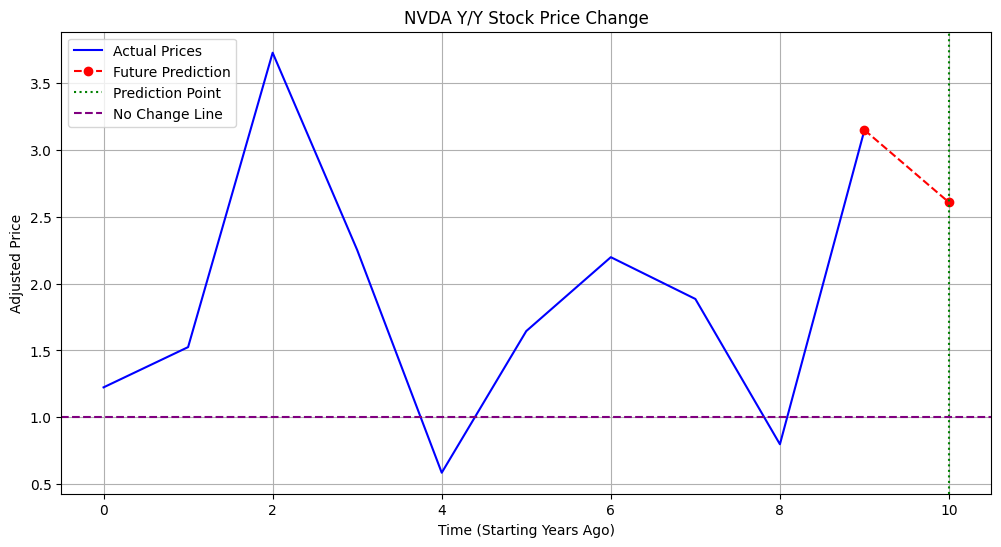

Predicted Price Change for the Next Year: 2.61


In [ ]:
import matplotlib.pyplot as plt

# Predict the next quarter
latest_sequence = scaled_features[-time_steps:].reshape(1, time_steps, scaled_features.shape[1])
predicted_scaled_future = model.predict(latest_sequence)
predicted_future_price = scaler_y.inverse_transform(predicted_scaled_future)

# Prepare historical data
historical_prices = scaler_y.inverse_transform(scaled_target).flatten()
timeline = list(range(len(historical_prices)))

# Extend timeline and prices for future prediction
extended_timeline = timeline + [timeline[-1] + 1]
extended_prices = list(historical_prices) + [predicted_future_price[0][0]]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(timeline[0: -1], historical_prices[0: -1], label="Actual Prices", color="blue", linestyle="-")

plt.plot([timeline[-2], extended_timeline[-2]], [historical_prices[-2], predicted_future_price[0][0]], 
         label="Future Prediction", color="red", linestyle="--", marker='o')

# Add a horizontal line at y = 1
plt.axhline(y=1, color='purple', linestyle='--', label="No Change Line")

plt.title("NVDA Y/Y Stock Price Change")
plt.xlabel("Time (Starting Years Ago)")
plt.ylabel("Adjusted Price")
plt.legend(loc="best")
plt.grid()
plt.show()

print(f"Predicted Price Change for the Next Year: {predicted_future_price[0][0]:.2f}")


In [104]:
# Debugging outputs to ensure correctness
print("Original Data Shape:", data.shape)
print("Scaled Features Shape:", scaled_features.shape)
print("Scaled Target Shape:", scaled_target.shape)

# Check for NaN in scaled data
print("NaN in Scaled Features:", np.isnan(scaled_features).sum())
print("NaN in Scaled Target:", np.isnan(scaled_target).sum())

# Inspect the first feature-target pair after sequence creation
print("First Sequence (X):", X[0])
print("First Target (y):", y[0])

# Ensure model is compiled correctly
print("Model Summary:")
model.summary()

# Check prediction shape
print("Latest Sequence Shape:", latest_sequence.shape)


Original Data Shape: (33, 135)
Scaled Features Shape: (33, 70)
Scaled Target Shape: (33, 1)
NaN in Scaled Features: 0
NaN in Scaled Target: 0
First Sequence (X): [[0.32112131 0.19037496 0.         ... 0.23918575 0.22281167 0.28698225]
 [0.20737812 0.16140343 0.         ... 0.45547074 0.43501326 0.50591716]
 [0.32020499 0.         0.         ... 0.44274809 0.4270557  0.49408284]
 ...
 [0.05301115 0.73564024 0.         ... 0.81933842 0.79310345 0.77514793]
 [0.12966011 0.33501348 0.         ... 0.71755725 0.70557029 0.68639053]
 [0.24182519 0.40704784 0.         ... 0.80152672 0.77188329 0.73964497]]
First Target (y): [0.69819891]
Model Summary:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 128)            │       101,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,053 (1.17 MB)

 Trainable params: 102,017 (398.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 204,036 (797.02 KB)

Latest Sequence Shape: (1, 28, 70)
